In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [45]:
def getShape(img_3D):
    length = img_3D.shape[0]
    width = img_3D.shape[1]
    colorChannel = img_3D.shape[2]
    return length,width,colorChannel
    
def highlightDistinguish(img_3D):
    length,width,colorChannel = getShape(img_3D)
    if(colorChannel != 3):
        print("颜色通道异常！")
    else:
        img_2D = np.reshape(img_3D,(-1,3))
        I_min = np.zeros(img_2D.shape[0])
        for i in range(I_min.shape[0]):
            I_min[i] = img_2D[i,:].min()
        
        T_offsetHighlight = 2*np.mean(I_min)+0.5*np.std(I_min)
        offset_highlight = np.zeros(img_2D.shape[0])
        for i in range(offset_highlight.shape[0]):
            if (I_min[i]>T_offsetHighlight):
                offset_highlight[i] = T_offsetHighlight
            else:
                offset_highlight[i] = I_min[i]
                
        I_highlightDetection = np.zeros(img_2D.shape[0])
        I_diffuseDetection = np.zeros(img_2D.shape[0])
        meanOfI_min = np.mean(I_min)
        for i in range(img_2D.shape[0]):
            if(offset_highlight[i] > 2*meanOfI_min):
                I_highlightDetection[i] = 1
            else:
                I_diffuseDetection[i] = 1
        
                
        T_offsetMSF = 2*np.mean(I_min)+0.5*np.std(I_min)
        offset_MSF = np.zeros(img_2D.shape[0])
        for i in range(offset_MSF.shape[0]):
            if (I_min[i]>T_offsetMSF):
                offset_MSF[i] = T_offsetMSF
            else:
                offset_MSF[i] = I_min[i]
        MSFimg_2D = img_2D.copy()
        for i in range(MSFimg_2D.shape[0]):
            MSFimg_2D[i] = MSFimg_2D[i]-I_min[i]+offset_MSF[i]
        MSFimg_3D = np.reshape(MSFimg_2D,(length,width,colorChannel))
        
        return I_highlightDetection,I_diffuseDetection,MSFimg_3D

def showHighlight(img_3D,strr):
    img_2D = np.reshape(img_3D,(-1,3))
    deHighlightImg_2D = img_2D.copy()
    I_highlightDetection,_ ,_= highlightDistinguish(img_3D)
    for i in range(deHighlightImg_2D.shape[0]):
        if(I_highlightDetection[i] == 1):
            deHighlightImg_2D[i] = [0,0,0]
    deHighlightImg_3D = np.reshape(deHighlightImg_2D,img_3D.shape)
#     im = Image.fromarray(deHighlightImg_3D)
#     im.save('./output/deHighlightImg_'+strr+'.png')
    plt.imshow(deHighlightImg_3D)
    plt.axis('off')
    plt.show()

def showMSF(img_3D,strr):
    _,_,MSFimg = highlightDistinguish(img_3D)
#     im = Image.fromarray(MSFimg)
#     im.save('./output/MSFimg'+strr+'.png')
    plt.imshow(MSFimg)
    plt.axis('off')
    plt.show()
    
def getLuminanceValue(img_clip):
    return 0.27*img_clip[0]+0.67*img_clip[1]+0.06*img_clip[2]
#     return 0.33*img_clip[0]+0.33*img_clip[1]+0.33*img_clip[2]

def getHF(MSFimg_3D,img_3D,I_highlightDetection,I_diffuseDetection):
    MSFimg_2D = np.reshape(MSFimg_3D,(-1,3))
    img_2D = np.reshape(img_3D,(-1,3))
   
    highlightImg_2D = img_2D.copy()
    diffuseImg_2D = img_2D.copy()
    
    for i in range(highlightImg_2D.shape[0]):
        if(I_highlightDetection[i] == 1):
            diffuseImg_2D[i] = [0,0,0]
            operator = 1+np.exp(-14*np.power((getLuminanceValue(highlightImg_2D[i])/255),1.6))*1.025
            highlightImg_2D[i]*operator
        else:
            highlightImg_2D[i] = [0,0,0]
    HFimg_3D =  np.reshape(highlightImg_2D+diffuseImg_2D,img_3D.shape)
#     plt.imshow(HFimg_3D)
#     plt.axis('off')
#     plt.show()
    return HFimg_3D


def getHDR(img_3D,strr):
    I_highlightDetection,I_diffuseDetection,MSFimg = highlightDistinguish(img_3D)
    I_HighlightFree_3D = getHF(MSFimg, img_3D, I_highlightDetection, I_diffuseDetection)
    plt.imshow(I_HighlightFree_3D)
    plt.axis('off')
    plt.show()
    
    I_HighlightFree_2D = np.reshape(I_HighlightFree_3D,(-1,3))
#     print(I_HighlightFree_2D)
    
    L_HighlightFree_2D = np.zeros((I_HighlightFree_2D.shape[0],1))
    for i in range(L_HighlightFree_2D.shape[0]):
        L_HighlightFree_2D[i] = getLuminanceValue(I_HighlightFree_2D[i])
#     print(L_HighlightFree_2D)
    
    L_HighlightFree_sum = 0
    for i in range(I_HighlightFree_2D.shape[0]):
        L_HighlightFree_sum += np.log(0.001+L_HighlightFree_2D[i])
    L_HighlightFree_exp_logMean = np.exp(L_HighlightFree_sum/I_HighlightFree_2D.shape[0])
#     print(L_HighlightFree_exp_logMean)
    
    scaled_L_HighlightFree_2D = (0.07/L_HighlightFree_exp_logMean)*L_HighlightFree_2D
#     print(scaled_L_HighlightFree_2D)
    
    toneMapping_L_HighlightFree_2D = scaled_L_HighlightFree_2D.copy()
    for i in range(toneMapping_L_HighlightFree_2D.shape[0]):
#         toneMapping_L_HighlightFree_2D[i] = scaled_L_HighlightFree_2D[i]/(1+scaled_L_HighlightFree_2D[i])
        toneMapping_L_HighlightFree_2D[i] = scaled_L_HighlightFree_2D[i]*(1+(scaled_L_HighlightFree_2D[i]/np.power(0.35,2)))/(1+scaled_L_HighlightFree_2D[i])
#     print(toneMapping_L_HighlightFree_2D)
    
    HDRimg_2D = np.reshape(img_3D,(-1,3))
    for i in range(HDRimg_2D.shape[0]):
        HDRimg_2D[i] = [0,0,0]
        HDRimg_2D[i] = I_HighlightFree_2D[i]*L_HighlightFree_2D[i]/(255*toneMapping_L_HighlightFree_2D[i])
#         print(L_HighlightFree_2D[i]/(255*toneMapping_L_HighlightFree_2D[i]))
        
    HDRimg_3D = np.reshape(HDRimg_2D,img_3D.shape)
    im = Image.fromarray(HDRimg_3D)
    im.save('./output/HDRImg_'+strr+'.png')
    plt.imshow(HDRimg_3D)
    plt.axis('off')
    plt.show()
#     print(HDRimg_2D)

In [6]:
# img1=np.array(Image.open('./data/img_001.png'))
# img2=np.array(Image.open('./data/img_002.png'))
# img3=np.array(Image.open('./data/img_003.png'))
# img4=np.array(Image.open('./data/img_004.png'))
# img5=np.array(Image.open('./data/img_005.png'))
# img6=np.array(Image.open('./data/img_006.png'))
# img7=np.array(Image.open('./data/img_007.jpg'))
# img8=np.array(Image.open('./data/img_008.jpg'))

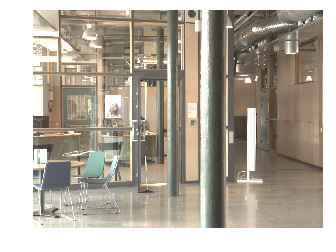

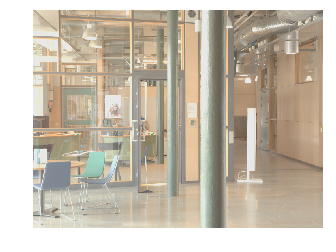

In [12]:
img3=np.array(Image.open('./data/img_003.png'))
getHDR(img3,'003')

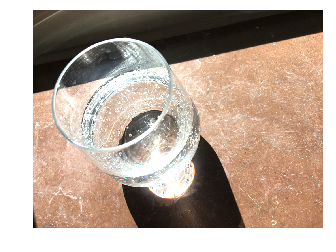

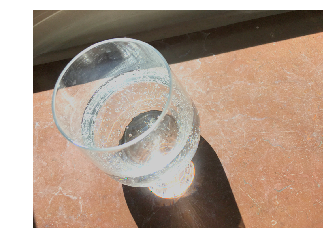

In [28]:
img5=np.array(Image.open('./data/img_005.png'))
getHDR(img5,'005')

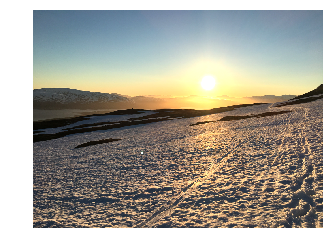

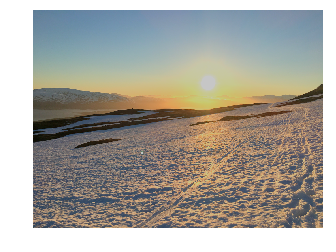

In [26]:
img6=np.array(Image.open('./data/img_006.png'))
getHDR(img6,'006')

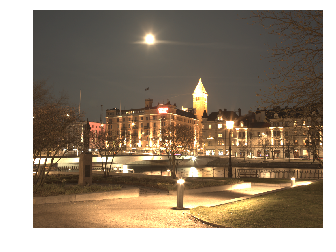

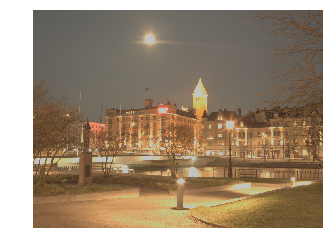

In [17]:
img1=np.array(Image.open('./data/img_001.png'))
getHDR(img1,'001')

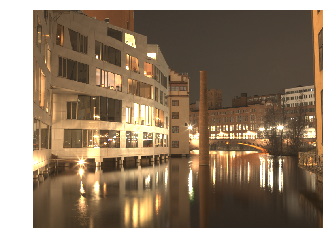

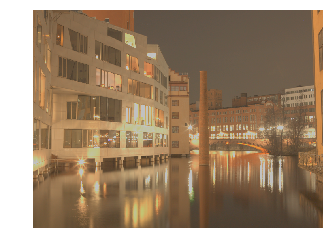

In [18]:
img2=np.array(Image.open('./data/img_002.png'))
getHDR(img2,'002')

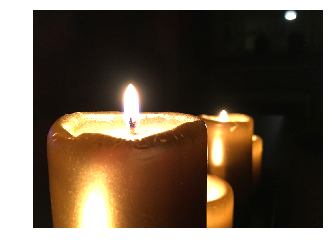

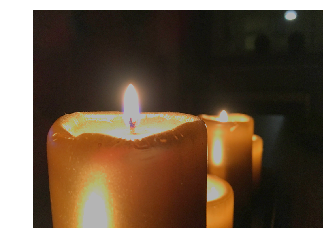

In [36]:
img4=np.array(Image.open('./data/img_004.png'))
getHDR(img4,'004')

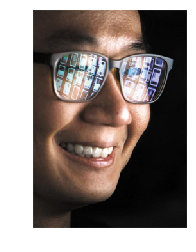

/Users/ethan/anaconda3/envs/python35/lib/python2.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in divide


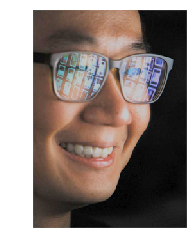

In [43]:
img7=np.array(Image.open('./data/img_007.jpg'))
getHDR(img7,'007')

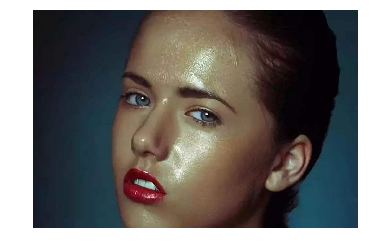

/Users/ethan/anaconda3/envs/python35/lib/python2.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in divide


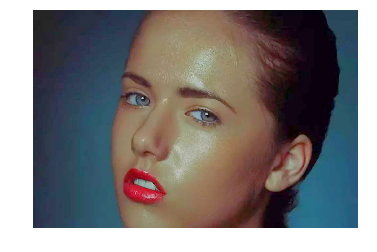

In [46]:
img8=np.array(Image.open('./data/img_008.jpg'))
getHDR(img8,'008')

In [ ]:
showHighlight(img1,'001')
showHighlight(img2,'002')
showHighlight(img3,'003')
showHighlight(img4,'004')
showHighlight(img5,'005')
showHighlight(img6,'006')
showHighlight(img7,'007')
showHighlight(img8,'008')

In [ ]:
showMSF(img1,'001')
showMSF(img2,'002')
showMSF(img3,'003')
showMSF(img4,'004')
showMSF(img5,'005')
showMSF(img6,'006')
showMSF(img7,'007')
showMSF(img8,'008')